In [162]:
%load_ext autoreload
%autoreload 2
from paths import *

from matplotlib import pyplot as plt
import torch
from src.SERS_dataset import IterDataset
from src.generate_data2 import pseudoVoigtSimulatorTorch
from src.plotting.save_plot import save_plot
from src.plotting.VAE_plotting import plot_losses_3_2, plt_recons_with_dist, plt_sigma_as_func_of_alpha_and_c, plot_kernels, slide_kernel_over_signal
# import make_axes_locatable
import numpy as np
import dill
import io

# matplotlib style seaborn-whitegrid
plt.style.use('seaborn-whitegrid')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\andre\AppData\Local\Temp\ipykernel_34896\1071115275.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [145]:
# load model that has been trained on GPU on CPU. Source https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(dill.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

def load_dill(file_name, experiment):
    file_name = os.path.join(results_dir, experiment, file_name)
    with open(file_name, 'rb') as f:
        contents = CPU_Unpickler(f).load()
    autoencoder = contents["model"]
    train_loss = contents["train_loss"]
    generator_num = contents["generator"]

    return autoencoder, train_loss, generator_num

In [164]:
model_name = "curious-deluge-703"
# model_name = "radiant-sponge-688"
autoencoder, train_loss, generator_num = load_dill(f"{model_name}.dill", "3_3_VAE_voigt_decoder_CNN")

In [151]:
ps = pseudoVoigtSimulatorTorch(500)
generator = ps.predefined_generator(generator_num)
dset_train = IterDataset(generator)
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=100, pin_memory=cuda)

x, y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)
z, mu, logvar = autoencoder.encode(x)
sigma = torch.exp(0.5 * logvar)
x_hat = autoencoder.decode(z)
x_hat_mu = autoencoder.decode(mu)

x = x.cpu().detach().numpy()
x_hat = x_hat.cpu().detach().numpy()
x_hat_mu = x_hat_mu.cpu().detach().numpy()
sigma = sigma.cpu().detach().numpy()
mu = mu.cpu().detach().numpy()
z = z.cpu().detach().numpy()


MSE = np.mean((x - x_hat)**2, axis=1).mean()
MSE_mu = np.mean((x - x_hat_mu)**2, axis=1).mean()


print(MSE)
print(MSE_mu)

0.3032374
0.30317715


[0.00225224 0.00097798 0.00183184 0.00066127 0.00102382 0.00087683]


<Figure size 800x550 with 0 Axes>

<Figure size 1500x1100 with 0 Axes>

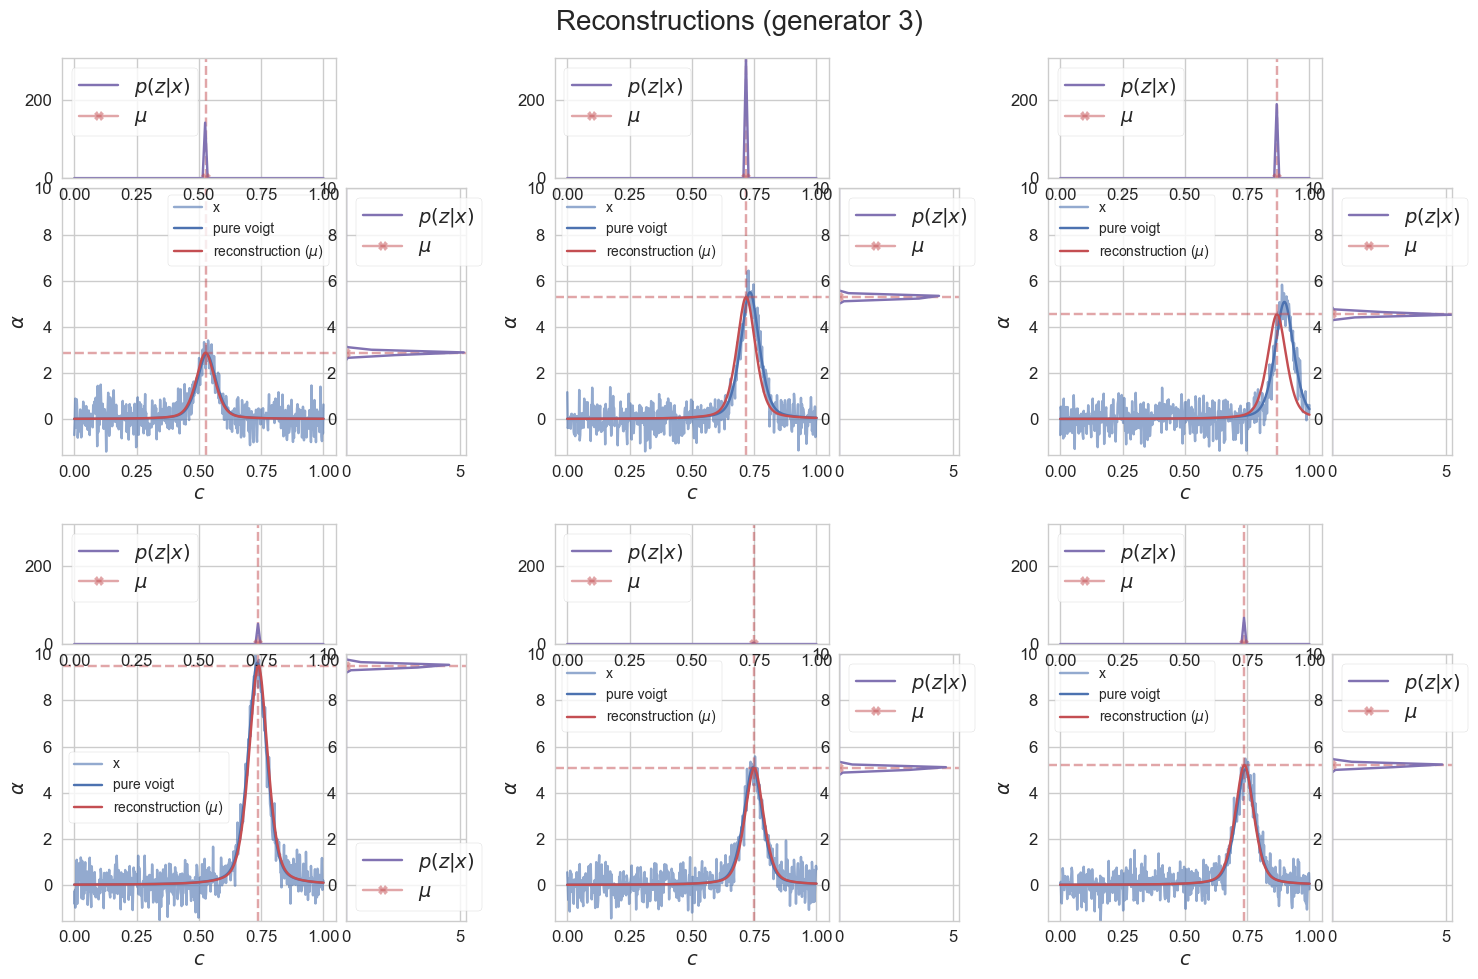

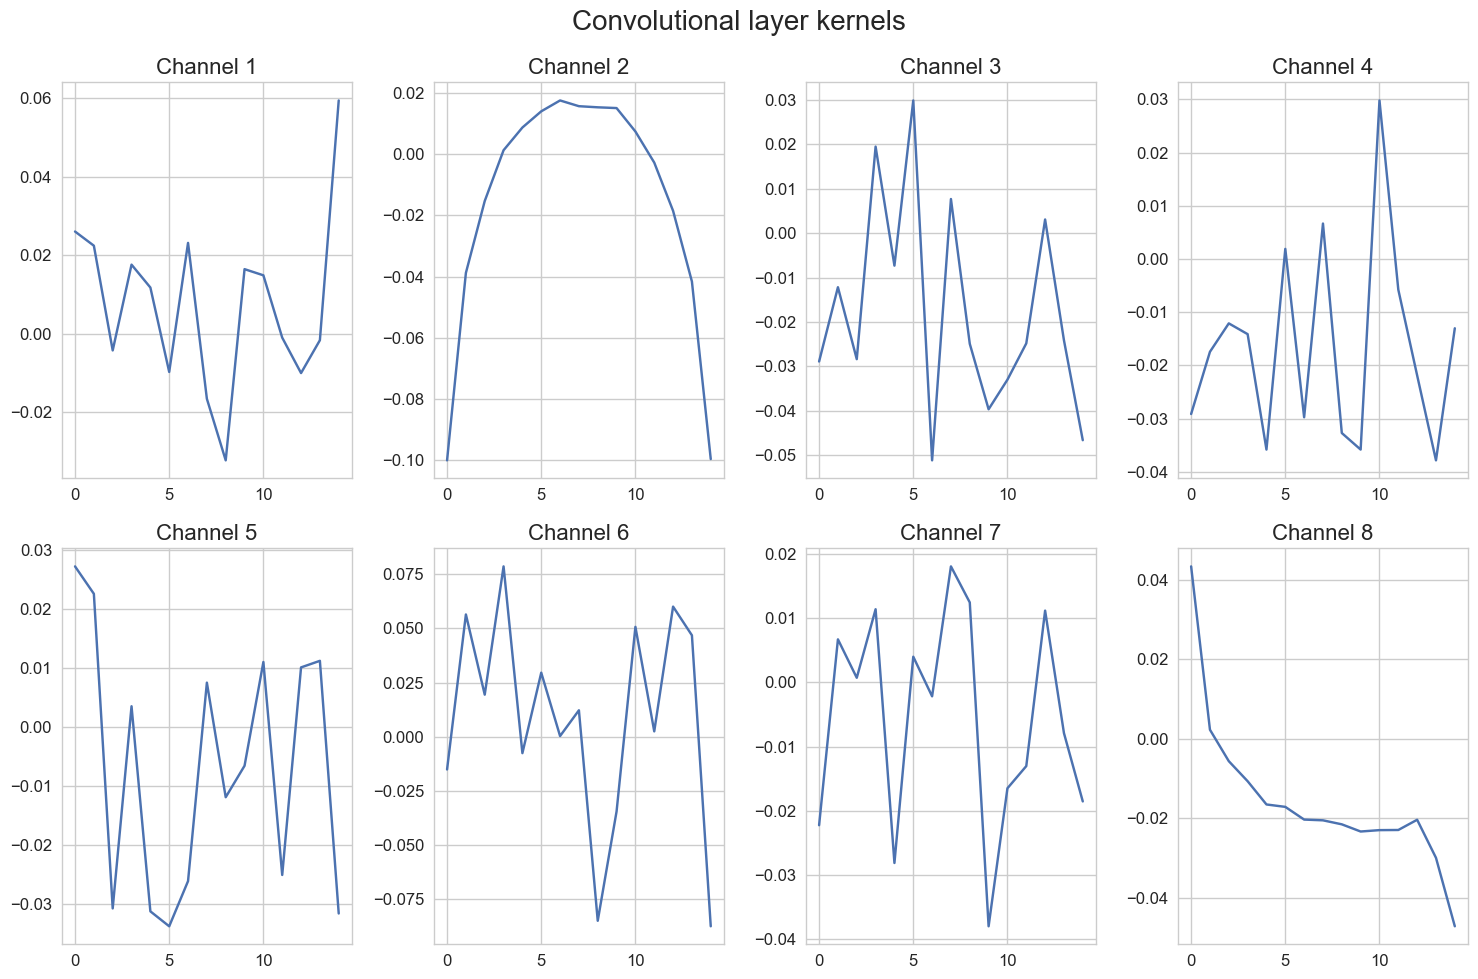

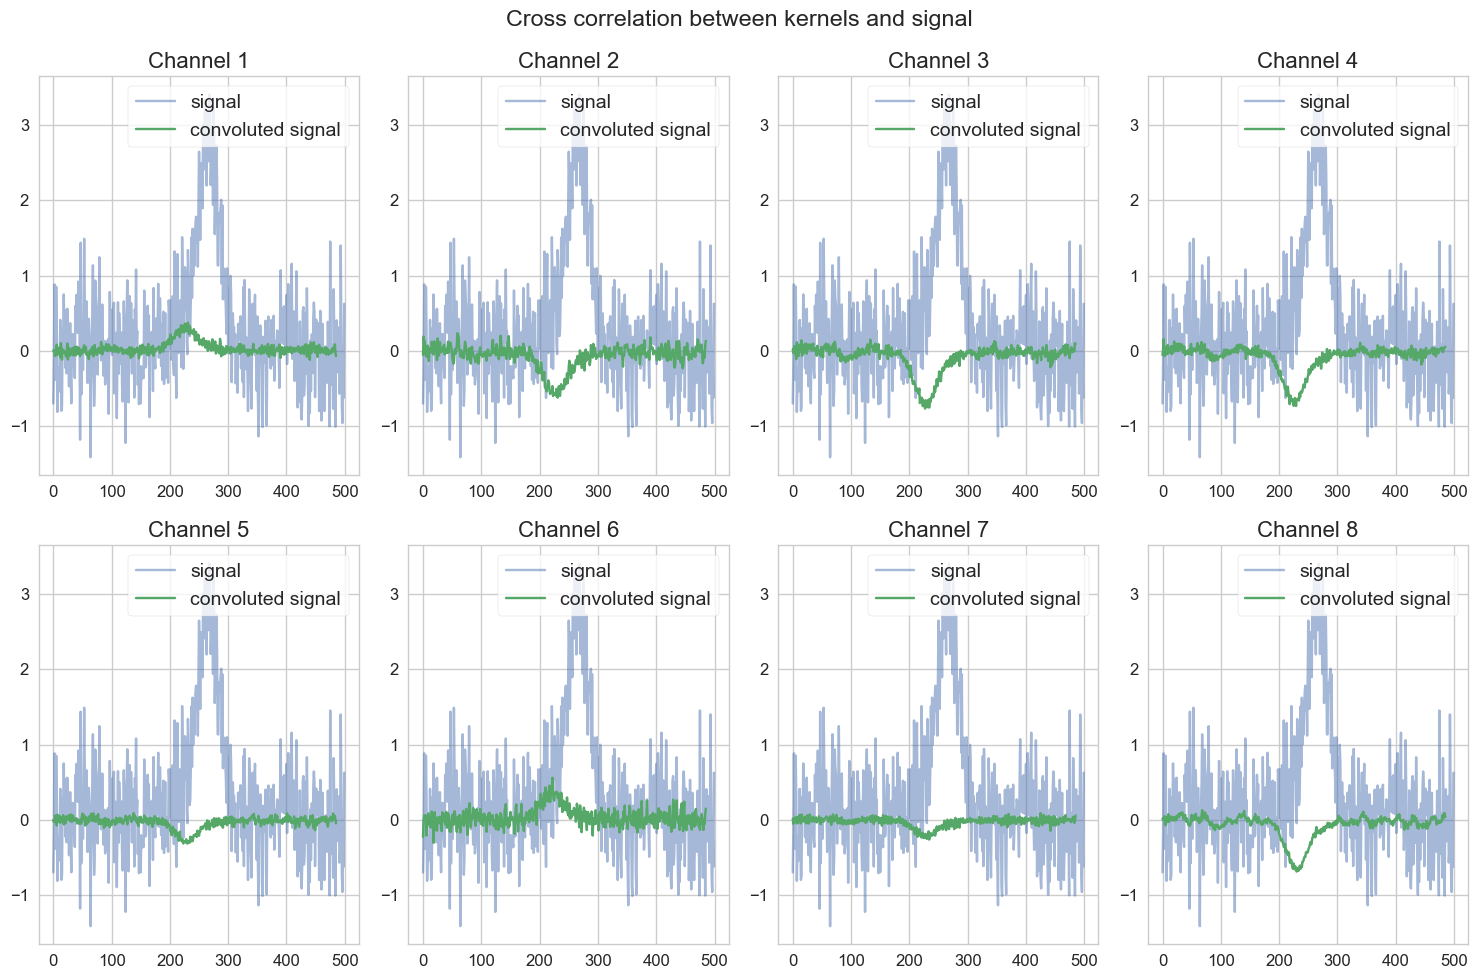

In [167]:
plot =  plot_losses_3_2(train_loss, 3)
save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt_CNN", "vae_voigt_CNN_losses"), ["pdf", "png"])

# print first 6 sigmas
print(sigma[:6,0])
# x, x_hat_mu, mu, sigma, y, generator_num, w, h
plot = plt_recons_with_dist(x, x_hat_mu, mu, sigma, y, 3, 3, 2)
save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt_CNN", "vae_voigt_CNN_reconstructions"), ["pdf", "png"])

plot = plot_kernels(autoencoder, layer_num=0)
save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt_CNN", "vae_voigt_CNN_kernels"), ["pdf", "png"])

plot = slide_kernel_over_signal(autoencoder, x[0], layer_num=0)
save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt_CNN", "vae_voigt_CNN_kernel_on_signal"), ["pdf", "png"])

plot = plt_sigma_as_func_of_alpha_and_c(mu, sigma, y)
save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt_CNN", "vae_voigt_CNN_sigmaf"), ["pdf", "png"])
